<a href="https://colab.research.google.com/github/khazzan/toolwearID/blob/main/Tool_Wear_Detection3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
#@title Import packages and libraries
!pip install -q tflite-model-maker
!sudo apt -y install libportaudio2
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools

!pip install -q opencv-python-headless==4.1.2.30
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0
!git clone https://github.com/khazzan/toolwearID.git

import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1build1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
ERROR: Could not find a version that satisfies the requirement opencv-python-headless==4.1.2.30 (from versions: 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.14.51, 3.4.14.53, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48, 4.5.2.52, 4.5.2.54, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66, 4.7.0.68, 4.7.0.72)
ERROR: No matching distribution found for opencv-python-headless==4.1.2.30
Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Successfully uninstalled tensorflow-2.8.0
fatal: destination path 'toolwearID' already exists and is not an empty directory.


In [59]:
#@title Image Dataset
dataset_is_split = True
use_custom_dataset = True
if not use_custom_dataset:
  train_data, validation_data, test_data = object_detector.DataLoader.from_csv('wear_ml_use2.csv')
label_map = {1: 'flank_wear'} 

train_images_dir = 'toolwearID/split-dataset2/train/images'
train_annotations_dir = 'toolwearID/split-dataset2/train/annotations'
val_images_dir = 'toolwearID/split-dataset2/validation/images'
val_annotations_dir = 'toolwearID/split-dataset2/validation/annotations'
test_images_dir = 'toolwearID/split-dataset2/test/images'
test_annotations_dir = 'toolwearID/split-dataset2/test/annotations'

train_data = object_detector.DataLoader.from_pascal_voc(
        train_images_dir, train_annotations_dir, label_map=label_map)
validation_data = object_detector.DataLoader.from_pascal_voc(
        val_images_dir, val_annotations_dir, label_map=label_map)
test_data = object_detector.DataLoader.from_pascal_voc(
        test_images_dir, test_annotations_dir, label_map=label_map)

import random
images_path = test_images_dir if dataset_is_split else os.path.join(test_dir, "images")
filenames = os.listdir(os.path.join(images_path))
random_index = random.randint(0, len(filenames) -1)
!python3 -m pip install --extra-index-url https://google-coral.github.io/py-repo/ pycoral


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://google-coral.github.io/py-repo/


In [60]:
#@title Wear Detection
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

!python3 -m pip install tflite-runtime
!pip install tflite-support
import tflite_runtime.interpreter as tflite 
import cv2 as cv

from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file

def draw_objects(draw, objs, scale_factor, labels):
  """Draws the bounding box and label for each object."""
  COLORS = np.random.randint(0, 255, size = (len(labels), 3), dtype = np.uint8)
  for obj in objs:
    bbox = obj.bbox
    color = tuple(int(c) for c in COLORS[obj.id])
    draw.rectangle([(bbox.xmin * scale_factor, bbox.ymin * scale_factor),
                    (bbox.xmax * scale_factor, bbox.ymax * scale_factor)],
                   outline = color, width = 3)
    font = ImageFont.truetype("LiberationSans-Regular.ttf", size = 15)
    draw.text((bbox.xmin * scale_factor + 4, bbox.ymin * scale_factor + 4),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill = color, font = font)

# Load the TF Lite model

LABELS_FILENAME = 'toolwearID/tf-lite_model2/wear-labels2.txt'
TFLITE_FILENAME = 'toolwearID/tf-lite_model2/efficientdet-lite-wear2.tflite'

labels = read_label_file(LABELS_FILENAME)
interpreter = tflite.Interpreter(TFLITE_FILENAME)
interpreter.allocate_tensors()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
from google.colab.patches import cv2_imshow
INPUT_IMAGE = os.path.join(images_path, filenames[24])
image = Image.open(INPUT_IMAGE)
_, scale = common.set_resized_input(
    interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

# Run inference
interpreter.invoke()
objs = detect.get_objects(interpreter, score_threshold = 0.4, image_scale = scale)

# Resize again to a reasonable size for display
display_width = 500
scale_factor = display_width / image.width
height_ratio = image.height / image.width
image = image.resize((display_width, int(display_width * height_ratio)))
if (objs != 0):
  draw_objects(ImageDraw.Draw(image), objs, scale_factor, labels)
else:
  image = image
print(image)

ratio = 0.00771 # 441px = 3.341mm
if (len(objs) == 0):
  wear_edge = 0
  vb_max = wear_edge
else:
  for x in range(len(objs)):
    wear_edge = "{:.2f}".format(((objs[x][2][2]) - (objs[x][2][0])) * ratio)
    vb_max = "{:.2f}".format(((objs[x][2][3]) - (objs[x][2][1])) * ratio)
    print("wear_edge_" + str(x) + ": " + str(wear_edge) + " mm")
    print("vb_max_" + str(x) + ": " +str(vb_max) + " mm")

<PIL.Image.Image image mode=RGB size=500x500 at 0x7FC3D7269130>
wear_edge_0: 1.88 mm
vb_max_0: 0.96 mm


In [65]:
#@title Laser Path Generation
#Once the wear measurement has retrieve use that to inform the decision
#Function for tool reconditioning method should use the wear_edge and vb_max values
#if 2 or more regions are there sum the max value of each
# input tool shape and if chip breaker
#Parameters list for each in order = [%, kHz, mm/s, mm]

from tensorflow.python.ops.gen_data_flow_ops import parallel_dynamic_stitch
import numpy as np
import os
import math
import textwrap
import datetime

# Variables and Arrays =================================================
ProcessCode = ['G1 ', 'G0 ', 'G3 ']
MotionCode = ['ENABLE ', 'HOME ', 'RAPID ', 'REPEAT ', 'END REPEAT']
Mcodes = ['M2 ', 'M30 ', 'M46 ', 'M47 ']
Variables = ['$task[1]', '$task[2]', '$task[3]', '$task[4]']
ParameterCode = [';Fluence (%): ', ';Frequency (kHz): ', ';Feed Speed (mm/s): ', ';Pitch distance (mm): ']
LaserOn = '''   $DO [2].Z = 0
    DWELL .1
    $DO [1].Z = 1
    DWELL .1 \n'''
LaserOff = '''  $DO [1].Z = 0
    DWELL .1
    $DO [2].Z = 1
    DWELL .1 \n'''
ZeroOut = '''$WO[0].Z = 0
DWELL .1'''
axis3 = 'X Y Z' 
coord = ['Z', 'X', 'Y']
coordVal = ['61.5', '5.5', '64.0'] #expeirementally defined

filename = datetime.datetime.now()
parameters = ''
indent = '     '
indent2 = '          '

start = [] 
startVal = []
ablation_depth = 0.1 #is this pitch?

plg = [[85, 100, 750, 0.01], [100, 150, 50, 0.05]]
plm = [[70, 70, 1000, 0.01], [100, 100, 50, 0.01]]
plr = [85, 70, 1000, 0.01]
pln = [100, 100, 20, 0.005]
plp = [100, 200, 10, 0.005]
#Parameters from Chapter 4 - (should it be quoted in Jcm2?)

def axisConfig():
  global axistext
  global endtext
  global start
  global startVal

  axistext = ZeroOut + '\n' + (MotionCode[0] + axis3) +'\n'+ (MotionCode[1] + axis3) +'\n'+ 'INCREMENTAL'
  endtext = (MotionCode[1] + axis3) +'\n' + ZeroOut + '\n' + '\n' + Mcodes[1]
  startVal = [coord[0] + coordVal[0], coord[1] + coordVal[1], coord[2] + coordVal[2]]
  start = ProcessCode[0] + (startVal[0] +' ' + startVal[1] + ' ' + startVal[2])

  return axistext, endtext, startVal, start

def reconSelection(a, b, c):

  global fluence, frequency, feed_speed, pitch, parameters, additional, chipbreaker

  a = float(a) #wear_edge
  b = float(b) #vb_max

  if ((a < 0.3) and (b < 0.2)):
    print("no need to recondition")

  elif (((b >= 0.2) and (b < 0.4)) and (a < 0.5)) or ((b < 0.2) and ((a >= 0.3) and (a < 1.5))):
    print("plg option chosen")
    typeParameter = int(input('Enter high (1) or low (0) for conditions: '))
    fluence = plg[typeParameter][0]
    frequency = plg[typeParameter][1]
    feed_speed = plg[typeParameter][2]
    pitch = plg[typeParameter][3]

  elif (((b >= 0.2) and (b < 0.75)) and (a > 0.5)):
    print("plm option chosen")
    typeParameter = int(input('Enter high (1) or low (0) for conditions: '))
    fluence = plm[typeParameter][0]
    frequency = plm[typeParameter][1]
    feed_speed = plm[typeParameter][2]
    pitch = plm[typeParameter][3]

  elif ((b >= 0.75) and (b < 1.40)): #or (((b >= 0.4) and (b < 0.6)) and (a < 0.5)):
    print("plr option chosen to remove and reset edge")
    fluence = plr[0]
    frequency = plr[1]
    feed_speed = plr[2]
    pitch = plr[3]
    additional = input('PLA polishing recommended (Y/N): ')
  
  elif(b >= 1.40):
    print("too damaged to recondition - recycle")
 
  #c is if there is a chip breaker
  if (c == 1):
    print("need additional step pln + add extra lasr code to compensate")
    #integrate the simple chip breaker design made
    #only edge 
    chipbreaker = 0
  else:
    print("keep initial code")
    chipbreaker = 0
   
  parameters = ParameterCode[0] + str(fluence) \
    + '\n' + ParameterCode[1] + str(frequency) \
    + '\n' + ParameterCode[2] + str(feed_speed) \
    + '\n' + ParameterCode[3] + str(pitch)
  return fluence, frequency, feed_speed, pitch, parameters, additional, chipbreaker


def squarePathCode(a, b, c, d):
  #a = vb_max, b = wear_edge, c = pitch, d = feed_speed
  a = (int(math.ceil(a)))
  b = (int(math.ceil(b)))
  no_repeat = str(a/ablation_depth) 

  path_repeat = str(b/c)
  
  pitch_text = (Variables[0] + ' = ' + str(c))

  delta_Z_text = (Variables[1] + ' = ' + str(ablation_depth))

  no_repeat_text = MotionCode[3] + str(no_repeat)

  path_repeat_text = MotionCode[3] + str(path_repeat)

  sPath = pitch_text + '\n' + delta_Z_text + '\n'+ '\n' + no_repeat_text + '\n' + indent + path_repeat_text \
    + '\n' + indent + LaserOn \
    + '\n' + indent2 + (ProcessCode[0] + (coord[1] + str(b)) + (' F' + str(d))) \
    + '\n' + indent2 + (ProcessCode[0] + (coord[1] +str(-b)) + (' F'+ str(d))) \
    + '\n' + indent2 + (ProcessCode[0] + (coord[2] + '(-' + Variables[0] +')')) \
    + '\n' + indent + MotionCode[4] + '\n' + indent + (ProcessCode[0] + (coord[0] + '(' + Variables[1] +')'))\
    + '\n' + indent + ProcessCode[0] + (coord[2]+str(b)) \
    + '\n' + MotionCode[4] + '\n' + '\n' + LaserOff \
    + '\n' + MotionCode[1] + axis3 + '\n' + start \
    + '\n' + '\n' + no_repeat_text + '\n' + indent + path_repeat_text \
    + '\n' + indent + LaserOn \
    + '\n' + indent2 + (ProcessCode[0] + (coord[2]+str(-b)) + (' F' + str(d))) \
    + '\n' + indent2 + (ProcessCode[0] + (coord[2]+str(b)) + (' F'+ str(d))) \
    + '\n' + indent2 + (ProcessCode[0] + (coord[1] + '(' + Variables[0] +')')) \
    + '\n' + indent + MotionCode[4] + '\n' + indent + (ProcessCode[0] + (coord[0] + '(' + Variables[1]+')'))\
    + '\n' + indent + ProcessCode[0] + (coord[1] +str(-b)) \
    + '\n' + MotionCode[4] + '\n' + '\n' + LaserOff \

  if (additional == 'Y'):
    fluence_1 = plp[0]
    frequency_1 = plp[1]
    feed_speed_1 = plp[2]
    pitch_1 = plp[3]

    no_repeat_text_1 = MotionCode[3] + str(2)
    path_repeat_1 = str(b/pitch_1)
    path_repeat_text_1 = MotionCode[3] + str(path_repeat_1)

    additional_text = '\n' + MotionCode[1] + axis3 + '\n' + start \
      + '\n' + '\n' + no_repeat_text_1 + '\n' + indent + path_repeat_text_1 \
      + '\n' + indent + LaserOn \
      + '\n' + indent2 + (ProcessCode[0] + (coord[1]+str(-b)) + (' F' + str(feed_speed_1))) \
      + '\n' + indent2 + (ProcessCode[0] + (coord[1]+str(b)) + (' F'+ str(feed_speed_1))) \
      + '\n' + indent2 + (ProcessCode[0] + (coord[2] + '(-' + Variables[0] +')')) \
      + '\n' + indent + MotionCode[4] + '\n' + indent + (ProcessCode[0] + (coord[0] + '(' + Variables[1]+')'))\
      + '\n' + indent + ProcessCode[0] + (coord[2] +str(b)) \
      + '\n' + MotionCode[4] + '\n' + '\n' + LaserOff \
    
    sPath = sPath + additional_text

  else: 
      None

  with open('Square004.txt', 'w+') as f:
    f.writelines(parameters)
    f.write('\n')
    f.write('\n')
    f.writelines (axistext)
    f.write('\n')
    f.write('\n')
    f.writelines (start)
    f.write('\n')
    f.write('\n')
    f.writelines(sPath)
    f.write('\n')
    f.write('\n')
    f.writelines(endtext)

wear_edge_0: 0.68 mm
vb_max_0: 0.7 mm
Does the tool have a chip breaker (0/1): 0
plm option chosen
Enter high (1) or low (0) for conditions: 0
keep initial code


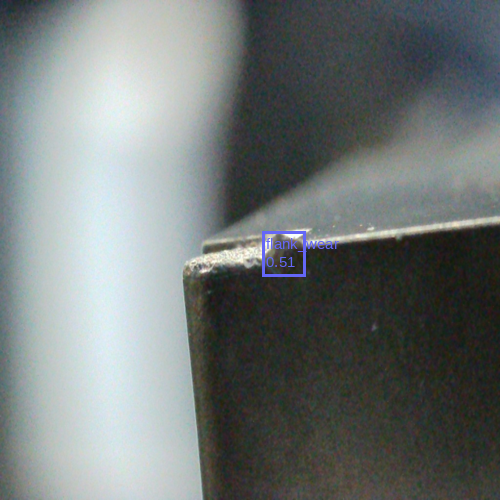

In [66]:
#@title In-situ images
insitu_images_dir = 'toolwearID/insitu-dataset'

insitu_filenames = os.listdir(os.path.join(insitu_images_dir))

TESTING_IMAGE = os.path.join(insitu_images_dir, insitu_filenames[1])
image = Image.open(TESTING_IMAGE)
_, scale = common.set_resized_input(
    interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

# Run inference
interpreter.invoke()
objs = detect.get_objects(interpreter, score_threshold = 0.4, image_scale = scale)

# Resize again to a reasonable size for display
display_width = 500
scale_factor = display_width / image.width
height_ratio = image.height / image.width
image = image.resize((display_width, int(display_width * height_ratio)))
if (objs != 0):
  draw_objects(ImageDraw.Draw(image), objs, scale_factor, labels)
else:
  image = image
image

objs
ratio = 0.00771 # 441px = 3.341mm
if (len(objs) == 0):
  wear_edge = 0
  vb_max = wear_edge
else:
  for x in range(len(objs)):
    wear_edge = float("{:.2f}".format(((objs[x][2][2]) - (objs[x][2][0])) * ratio))
    vb_max = float("{:.2f}".format(((objs[x][2][3]) - (objs[x][2][1])) * ratio))
    print("wear_edge_" + str(x) + ": " + str(wear_edge) + " mm")
    print("vb_max_" + str(x) + ": " +str(vb_max) + " mm")

#=======================================================================
# Generate Reconditioning Path
#=======================================================================
axisConfig()
cb = input('Does the tool have a chip breaker (0/1): ')
reconSelection(wear_edge, vb_max, cb)
squarePathCode(vb_max, wear_edge, pitch, feed_speed)
image